In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.weightstats import ttest_ind

from skimage.io import imread
import scipy.ndimage as sn

# Hypothesis Testing Exercise
## Comparing Distributions. Testing statistical hypotheses. p-value. Goodness of fit

### Problem 1. t-test
You're given a dataset which describes the age at death among members of the sovereignty, aristocracy, and gentry. There is an explanation [here](http://www.stat.ufl.edu/~winner/data/agedeath.txt) and the actual data is [here](http://www.stat.ufl.edu/~winner/data/agedeath.dat). Get to know the data; plot histograms and / or boxplots, or other graphs as needed. Note that all ages are only for a certain social class of people and they won't represent the entire population of people.

Do the mean ages differ significantly ($\alpha = 5\%$)? Perform a t-test. Do you need an independent or paired test?

In [3]:
age_of_death_data = pd.read_fwf("https://users.stat.ufl.edu/~winner/data/agedeath.dat", header = None)

age_of_death_data.columns = ["Type", "Death", "Index"]

summary = age_of_death_data.groupby("Type").Death.describe()

print("Age-at-death summary by social rank")
print()
print(summary)

Age-at-death summary by social rank

       count       mean        std  min   25%   50%   75%   max
Type                                                           
aris  2291.0  60.146224  17.428857  0.0  48.0  62.0  74.0  99.0
gent  2455.0  57.145010  18.107512  0.0  44.0  60.0  71.0  99.0
sovr  1440.0  54.093750  16.097867  0.0  43.0  56.0  66.0  97.0


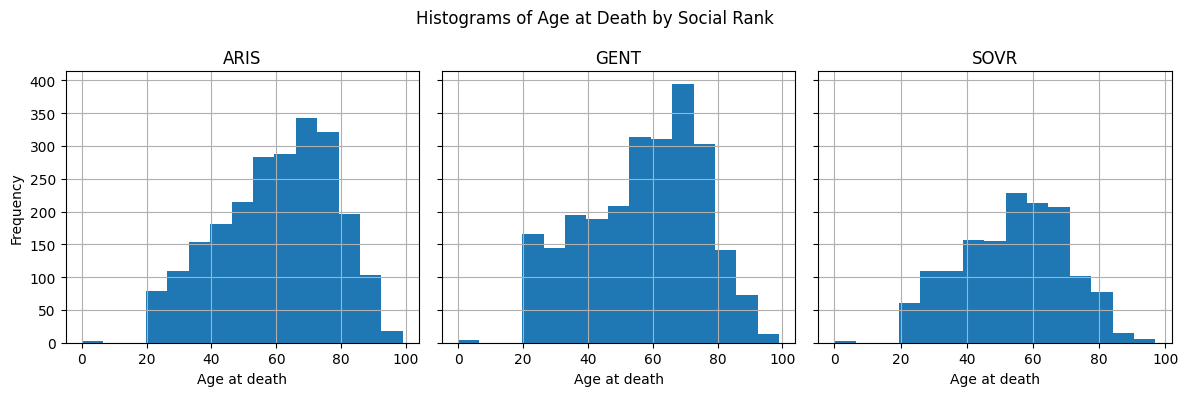

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

ranks = age_of_death_data.Type.unique()
for ax, rank in zip(axes, ranks):
    age_of_death_data[age_of_death_data.Type == rank].Death.hist(bins=15, ax=ax)
    ax.set_title(f"{rank.upper()}")  
    ax.set_xlabel("Age at death")
    
axes[0].set_ylabel("Frequency")
fig.suptitle("Histograms of Age at Death by Social Rank")
fig.tight_layout()
plt.show()

<Figure size 600x500 with 0 Axes>

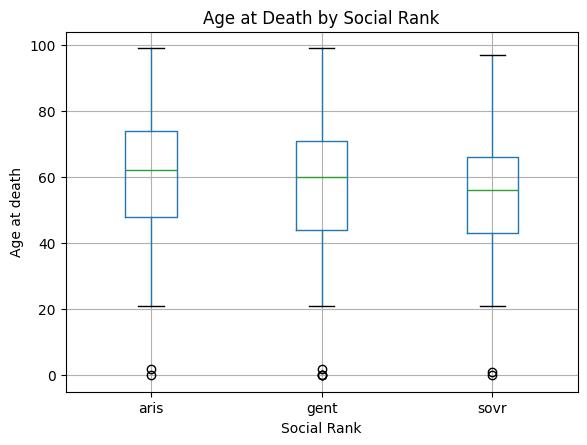

In [5]:
plt.figure(figsize=(6, 5))
age_of_death_data.boxplot(column="Death", by="Type")
plt.title("Age at Death by Social Rank")
plt.suptitle("")      
plt.xlabel("Social Rank")
plt.ylabel("Age at death")
plt.show()

In [6]:
sovr = age_of_death_data.loc[age_of_death_data.Type == "sovr", "Death"]
aris = age_of_death_data.loc[age_of_death_data.Type == "aris", "Death"]
gent = age_of_death_data.loc[age_of_death_data.Type == "gent", "Death"]

for g1, g2 in [("sovr", "aris"), ("sovr", "gent"), ("aris", "gent")]:
    t, p = st.ttest_ind(eval(g1), eval(g2))   
    print(f"{g1} vs {g2}:  t = {t:.2f},  p = {p:.4f}")

sovr vs aris:  t = -10.63,  p = 0.0000
sovr vs gent:  t = -5.29,  p = 0.0000
aris vs gent:  t = 5.81,  p = 0.0000


Let's try something else. In the `data/horse_beginners.dat` file, there's data about 8 people. Each person is a beginner in horse riding. They were asked to imagine how long their ride would take (for a fixed track length). After that, the actual times were measured.

Get acquainted with the data and draw some plots if you need (hint: boxplots are useful for comparing distributions). Are the people good at predicting their ride times? That is, are there significant differences between imagined and actual time (5%-level)? Also, is the imagined time **significantly longer** than the real time? Perform a t-test. Don't forget that the subjects are the same.

In [7]:
horse_data = pd.read_fwf("data/horse_beginners.dat")

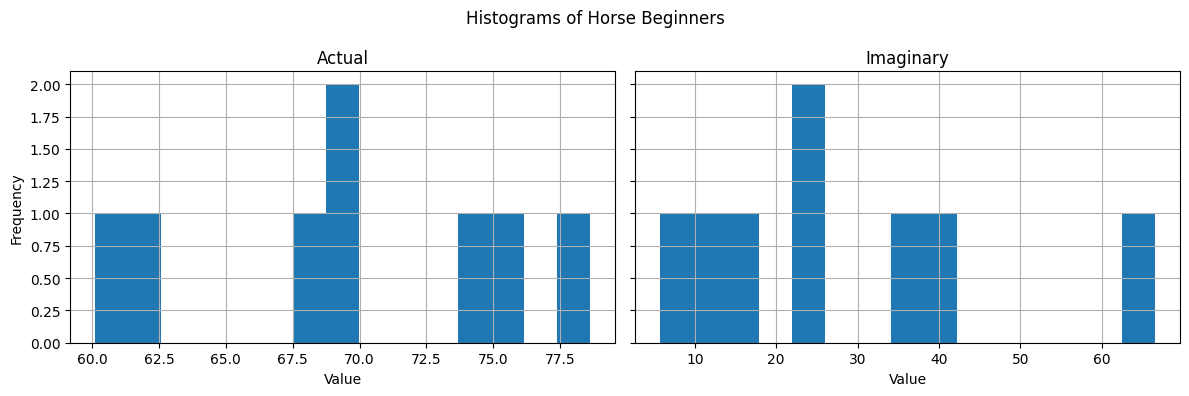

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

columns = ["Actual", "Imaginary"]
for ax, column in zip(axes, columns):
    horse_data[column].hist(bins=15, ax=ax)
    ax.set_title(column)  
    ax.set_xlabel("Value")
    
axes[0].set_ylabel("Frequency")
fig.suptitle("Histograms of Horse Beginners")
fig.tight_layout()
plt.show()

C:\Users\Jerry\AppData\Local\Temp\ipykernel_25552\1409395315.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


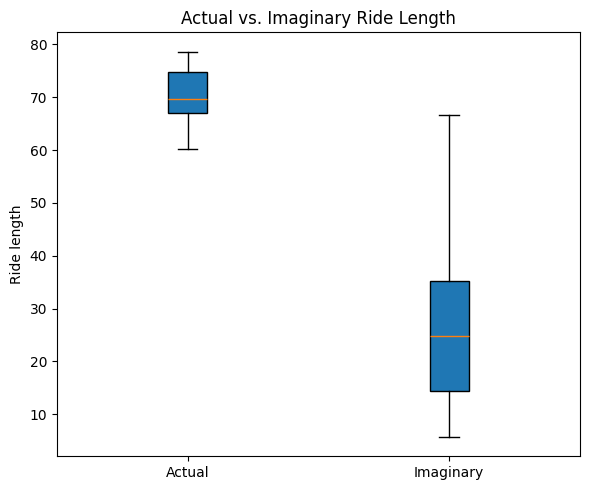

In [9]:
plt.figure(figsize=(6, 5))

plt.boxplot(
    [horse_data["Actual"], horse_data["Imaginary"]],
    labels=["Actual", "Imaginary"],
    patch_artist=True, 
)

plt.title("Actual vs. Imaginary Ride Length")
plt.ylabel("Ride length")
plt.tight_layout()
plt.show()

In [10]:
actual = horse_data["Actual"]
imagined = horse_data["Imaginary"]

t_stat, p_two_sided = st.ttest_rel(imagined, actual)
print(f"Two-sided test : t = {t_stat:6.2f},  p = {p_two_sided:7.4f}")

if t_stat > 0:
    p_one_sided = p_two_sided / 2.0
else:
    p_one_sided = 1.0 - p_two_sided / 2.0
print(f"One-sided test : t = {t_stat:6.2f},  p = {p_one_sided:7.4f}")

Two-sided test : t =  -6.19,  p =  0.0004
One-sided test : t =  -6.19,  p =  0.9998


### Problem 2. ANOVA
Read [this](http://www.itl.nist.gov/div898/education/anova/newcar.dat) dataset. Get acquainted with it and plot graphics. Note that it's formatted a bit oddly. First, you have to skip some rows; second, the target variable is first (in most datasets, it's the last one). Well, that shouldn't bother you :).

Do the rates differ significantly ($\alpha = 0,05$) between cities? Apply one-way ANOVA to find out.

**Hint:** You have to group all values by city. You can get a dictionary of groups like this:
```python
groups = { k: v.tolist() for k, v in cars.groupby("City").Rate }
```

After that, you can use ```*groups.values()``` to pass all dictionary values as separate arguments to a function.

In [11]:
new_car_data = pd.read_fwf("data/newcar.dat", skiprows = 25, header = None)
new_car_data.columns = ["Rate", "City"]
groups = { k: v.tolist() for k, v in new_car_data.groupby("City").Rate }

F, p = st.f_oneway(*groups.values())
print(f"F-stat = {F:5.2f},  p-value = {p:7.4f}")

F-stat =  4.83,  p-value =  0.0012


Well, most analyses aren't so simple. Let's have a look at another dataset. This one is located [here](http://www.itl.nist.gov/div898/education/anova/ratfeed.dat). Get acquainted with it.

This time, we've got two explanatory variables: amount and type of diet.

Perform one-way ANOVA to each variable separately, disregarding the other one. 

To do this, take for example the "Amount" variable. Group all weights by amount, disregarding the diet type. Perform ANOVA on the groups, like you did before. Repeat the same process with "Diet".

Do the groups differ significantly at the 5%-level?

In [12]:
rat_feed_data = pd.read_fwf("data/ratfeed.dat", skiprows = 25, header = None)
rat_feed_data.columns = ["Weight", "Amount", "Type"]

In [13]:
amount_groups = [g.values for _, g in rat_feed_data.groupby("Amount")["Weight"]]

F_amt, p_amt = st.f_oneway(*amount_groups)

type_groups = [g.values for _, g in rat_feed_data.groupby("Type")["Weight"]]

F_typ, p_typ = st.f_oneway(*type_groups)

print(f"ANOVA on Amount : F = {F_amt:6.2f}, p = {p_amt:7.4f}")
print(f"ANOVA on Diet : F = {F_typ:6.2f}, p = {p_typ:7.4f}")

ANOVA on Amount : F =  14.10, p =  0.0004
ANOVA on Diet : F =   0.48, p =  0.6232


Sometimes we have to take into account multiple values. In this case, we want to ask another question: Is there a significant difference between combinations of diet and amount? These are called **interacting variables**. Unfortunately, there isn't a quick and easy way to perform this test in `scipy.stats`, but `statsmodels` is another library which will come in handy.

We won't go into many details how it works but you basically create a linear model (`ols` stands for "ordinary least squares") and you provide a formula. The formula we want to use looks like this:
```python
formula = "Weight ~ C(Amount) + C(Diet) + C(Amount):C(Diet)"
```

`Weight`, `Amount` and `Diet` are the **column names** (i.e. variable names) in the dataset. `C(Amount)` tells the library to treat the variable as *categorical*, not numerical (e.g. diet 1 + diet 3 makes absolutely no sense). Finally `C(Amount):C(Diet)` means that we take the interaction between these categories (Cartesian product - every amount with every diet).

How do we read this formula? "The Weight column is proportional to the categories Amount, Diet and their interaction" (i.e. Weight is a linear combination of the three other variables).

We are now ready. Well, we could have done all this by hand as well, but why bother :)? Just create the linear model:
```python
model = ols(formula, rats).fit()
```

and the ANOVA table:
```python
table = statsmodels.stats.anova.anova_lm(model, typ = 2)
```

You can see there's "type 2" ANOVA chosen. If you're interested, you can read more about the three types of ANOVA [here](https://mcfromnz.wordpress.com/2011/03/02/anova-type-iiiiii-ss-explained/)

P. S.: The type of formulas we described above are typical for another popular language for statistics and data analysis, called **R**. They're also why many people hate R. They're good but need a bit of understanding and getting accustomed to. Case closed :D.

In [14]:
formula = "Weight ~ C(Amount) + C(Type) + C(Amount):C(Type)"  
model   = ols(formula, data=rat_feed_data).fit()

ANOVA_table = sm.stats.anova_lm(model, typ=2)
print(ANOVA_table)

                         sum_sq    df          F    PR(>F)
C(Amount)           3168.266667   1.0  14.766649  0.000322
C(Type)              266.533333   2.0   0.621129  0.541132
C(Amount):C(Type)   1178.133333   2.0   2.745520  0.073188
Residual           11586.000000  54.0        NaN       NaN


### Problem 3. Contingency Tables. $\chi^2$-test
Have a look at the dataset `data/Popular Kids.tsv` and its description `data/Popular Kids Description.txt`.

When we want to compare data across many categories, a useful way we can visualize it, is using **contingency tables** (or two-way tables). One variable goes to the rows, another one - to the columns of the table. The intersection cell represents the number of observations having this combination of values.

Try it now:
```python
pd.crosstab(kids.Grade, kids.Goals)
```

You can also specify multiple columns - this will create higher-dimensional tables. Keep in mind, however, that these are difficult to look at and understand. We're usually fine with two variables, three in some rare cases.

In [15]:
popular_kids_data = pd.read_table("data/Popular Kids.tsv")
popular_kids_data

,Gender,Grade,Age,Race,Urban/Rural,School,Goals,Grades,Sports,Looks,Money
0,boy,5,11,White,Rural,Elm,Sports,1,2,4,3
1,boy,5,10,White,Rural,Elm,Popular,2,1,4,3
2,girl,5,11,White,Rural,Elm,Popular,4,3,1,2
3,girl,5,11,White,Rural,Elm,Popular,2,3,4,1
4,girl,5,10,White,Rural,Elm,Popular,4,2,1,3
...,...,...,...,...,...,...,...,...,...,...,...
473,boy,6,11,White,Urban,Westdale Middle,Grades,4,1,2,3
474,boy,6,11,White,Urban,Westdale Middle,Sports,4,1,2,3
475,boy,6,11,White,Urban,Westdale Middle,Grades,4,2,1,3
476,boy,6,11,White,Urban,Westdale Middle,Popular,4,1,3,2


In [16]:
ct = pd.crosstab(popular_kids_data.Grade, popular_kids_data.Goals)
print(ct)

Goals  Grades  Popular  Sports
Grade                         
4          63       31      25
5          88       55      33
6          96       55      32


The **$\chi^2$**-test provides a way to test for association between two (or more) categorical variables. In this case, **Grade** and **Goals** seem to be good candidates. This is most easily done using the contingency table. Fortunately, `scipy.stats` has one such method (read the docs [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html)).

Note that this test doesn't specify what the relationship is. It just tells us that there might be a significant relationship.

Are goals related to grade? To what extent? Are these significant?
* $H_0$: No relation between Grade and Goals
* $H_1$: Some relation exists between Grade and Goals
* $\alpha = 0,05$

In [17]:
chi2, p, dof, expected = st.chi2_contingency(ct)

print(f"chi^2 = {chi2:.2f}, dof = {dof}, p-value = {p:.4f}")

chi^2 = 1.31, dof = 4, p-value = 0.8593


The school areas are also divided into "Urban", "Suburban" and "Rural". Are the school areas related to goals? Perform the same type of test. Is the difference significant now?

In [18]:
ct_area = pd.crosstab(popular_kids_data["Urban/Rural"], popular_kids_data.Goals)  
chi2_a, p_a, dof_a, expected_a = st.chi2_contingency(ct_area)

print(f"chi^2 = {chi2_a:.2f}, dof = {dof_a}, p-value = {p_a:.4f}")

chi^2 = 18.83, dof = 4, p-value = 0.0008


Feel free to continue exploring the dataset as you wish. You can find interesting data and relationships. 

**Note:** You'll see the catch of categorical variables - these are very difficult to visualize properly. Most plots just appear as symmetrical patterns of dots. You can rely on contingency tables and correlations to properly describe and explore these variables.

### Problem 4. Image Convolution
"Convolution" refers to a process similar to "mixing" two functions. It can be performed in one dimension (e.g. on audio data), or many dimensions. In this problem, we'll look at 2D convolution of images and what we can do with it.

Let's first read an image. Once again, to make things easier, we'll separate the channels. We can work on all three channels separately or at once but it's easier to work with one channel only.

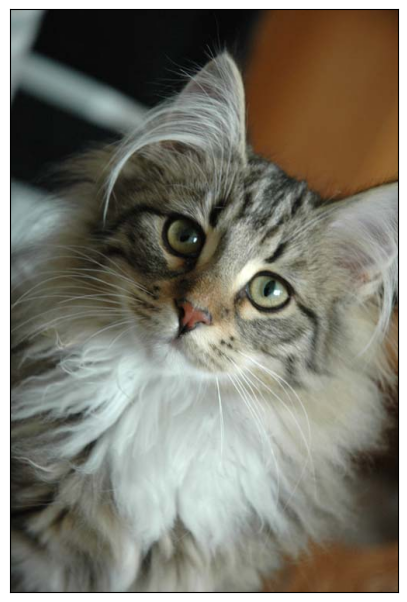

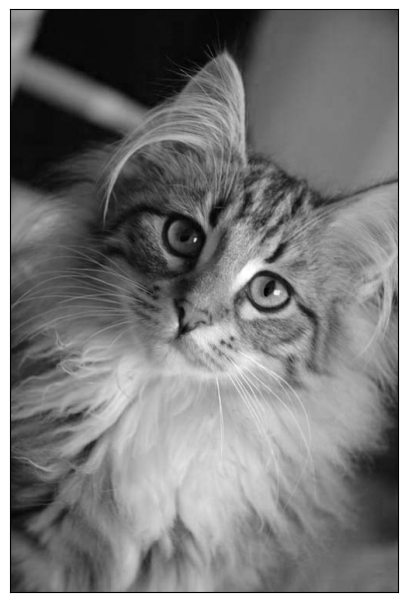

In [19]:
original_image = imread("https://upload.wikimedia.org/wikipedia/commons/d/d9/Norwegian_Forest_Cat_Portrait.JPG")

def display(image):
    # If there is only one channel to show, display it as grayscale
    cm = None
    if(len(image.shape)) == 2:
        cm = "gray"
    plt.figure(figsize = (5, 10))
    plt.imshow(image, cmap = cm)
    plt.xticks([])
    plt.yticks([])
    plt.show()

display(original_image)
r = original_image[:, :, 0]
display(r)

**Convolution** means taking a special square matrix (usually 3x3 or 5x5), called a **convolution kernel** and applying it to the image like this: the central pixel of the resulting image is the sum of element-wise products between the image and the kernel:
![Convolution example](convolution.png)

After that, the kernel moves 1px to the right and contiinues. It "slides" across the entire image. The edge pixels are a bit problematic but there are several ways to deal with that. The most common way is to copy whatever pixel value happened to be at the border.

![Border handling](border.png)

The algorithm is always the same. The output depends on the **kernel**. Different kernels produce different results: some detect edges (lines), others detect corners; some apply blurring and sharpening; some remove noise, etc.

The results can be useful for analyzing what's on the image, or just for artistic purposes.

Let's examine this filter, for example:

$$ F = \begin{bmatrix}
1/9 & 1/9 & 1/9 \\
1/9 & 1/9 & 1/9 \\
1/9 & 1/9 & 1/9
\end{bmatrix}
$$

This calculates the average of all surrounding pixels and basically smooths the image.

Note that in order to preserve brightness, the sum of all elements in $F$ must be equal to 1. If it's not, the image will be darker or brighter (which may or may not be a desired effect).

`scipy.ndimage` has a method for performing 1D and multi-dimensional convolution. Read the docs [here](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.ndimage.filters.convolve.html#scipy.ndimage.filters.convolve).

Apply the convolution. To see better how it performs, you can plot only a part of the image - this will zoom the entire thing. Compare the "before" and "after" images.

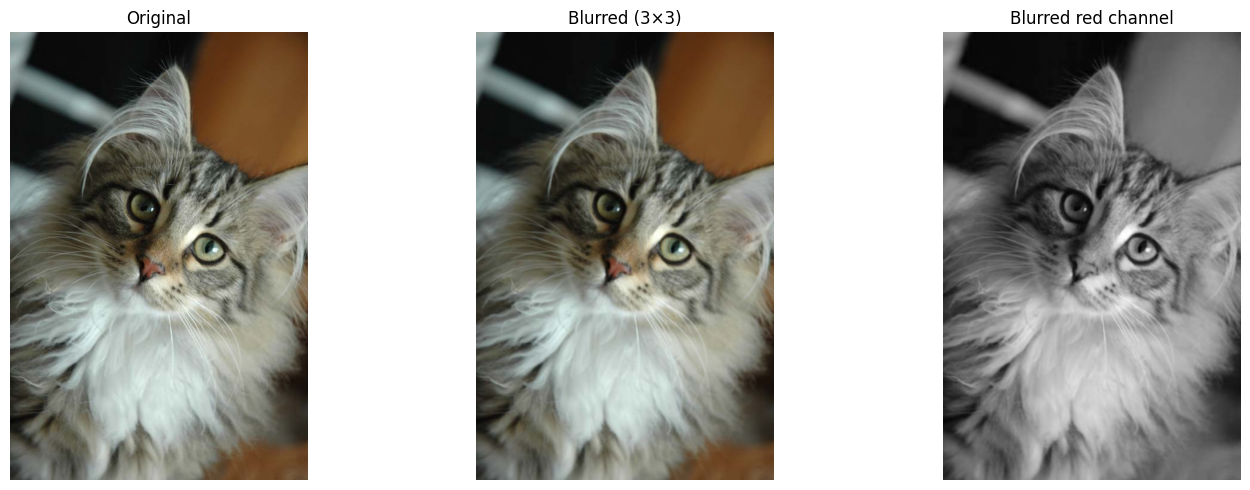

In [20]:
kernel = np.ones((3, 3), dtype=float) / 9.0

blurred_rgb = np.empty_like(original_image)

for ch in range(3):                                  
    blurred_rgb[:, :, ch] = sn.convolve(original_image[:, :, ch],
                                        kernel, mode='nearest')

r_blur = sn.convolve(r, kernel, mode='nearest')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(original_image)
axes[0].set_title("Original")
axes[0].axis('off')

axes[1].imshow(blurred_rgb)
axes[1].set_title("Blurred (3×3)")
axes[1].axis('off')

axes[2].imshow(r_blur, cmap='gray')
axes[2].set_title("Blurred red channel")
axes[2].axis('off')

plt.tight_layout()
plt.show()

Play around with more kernels (they're also called **filters**). You can find examples on the Internet, or you can create your own. Have fun :).

Try these filters:
* Gaussian blur
* Sobel edge detector - vertical, horizontal
* Corner detector
* Gradient detector
* Sharpening
* Unsharp mask

For each filter, show the result before and after its application.

Sources: <a href="https://en.wikipedia.org/wiki/Kernel_(image_processing)">Wikipedia</a>, [Image Kernels explained visually](http://setosa.io/ev/image-kernels/).

**Optional:** Think about you might use edge, corner and gradient detectors in image processing.

In [21]:
def to_gray(img):
    if img.ndim == 2:
        return img
    return (0.299 * img[..., 0] +
            0.587 * img[..., 1] +
            0.114 * img[..., 2]).astype(img.dtype)
    
def gaussian_blur(img, sigma=2):
    out = np.empty_like(img)
    for ch in range(3):
        out[..., ch] = sn.gaussian_filter(img[..., ch], sigma=sigma)
    return out

def sobel_x(img):
    return sn.sobel(to_gray(img), axis=1)

def sobel_y(img):
    return sn.sobel(to_gray(img), axis=0)

def gradient_magnitude(img):
    return np.hypot(sobel_x(img), sobel_y(img))

def sharpen(img):
    k = np.array([[0, -1, 0],
                  [-1, 5, -1],
                  [0, -1, 0]], dtype=float)
    out = np.empty_like(img)
    for ch in range(3):
        out[..., ch] = sn.convolve(img[..., ch], k)
    return out

def unsharp_mask(img, sigma=2, amount=1.5):
    blurred = gaussian_blur(img, sigma)
    res = img + amount * (img - blurred)
    return np.clip(res, 0, 255).astype(img.dtype)

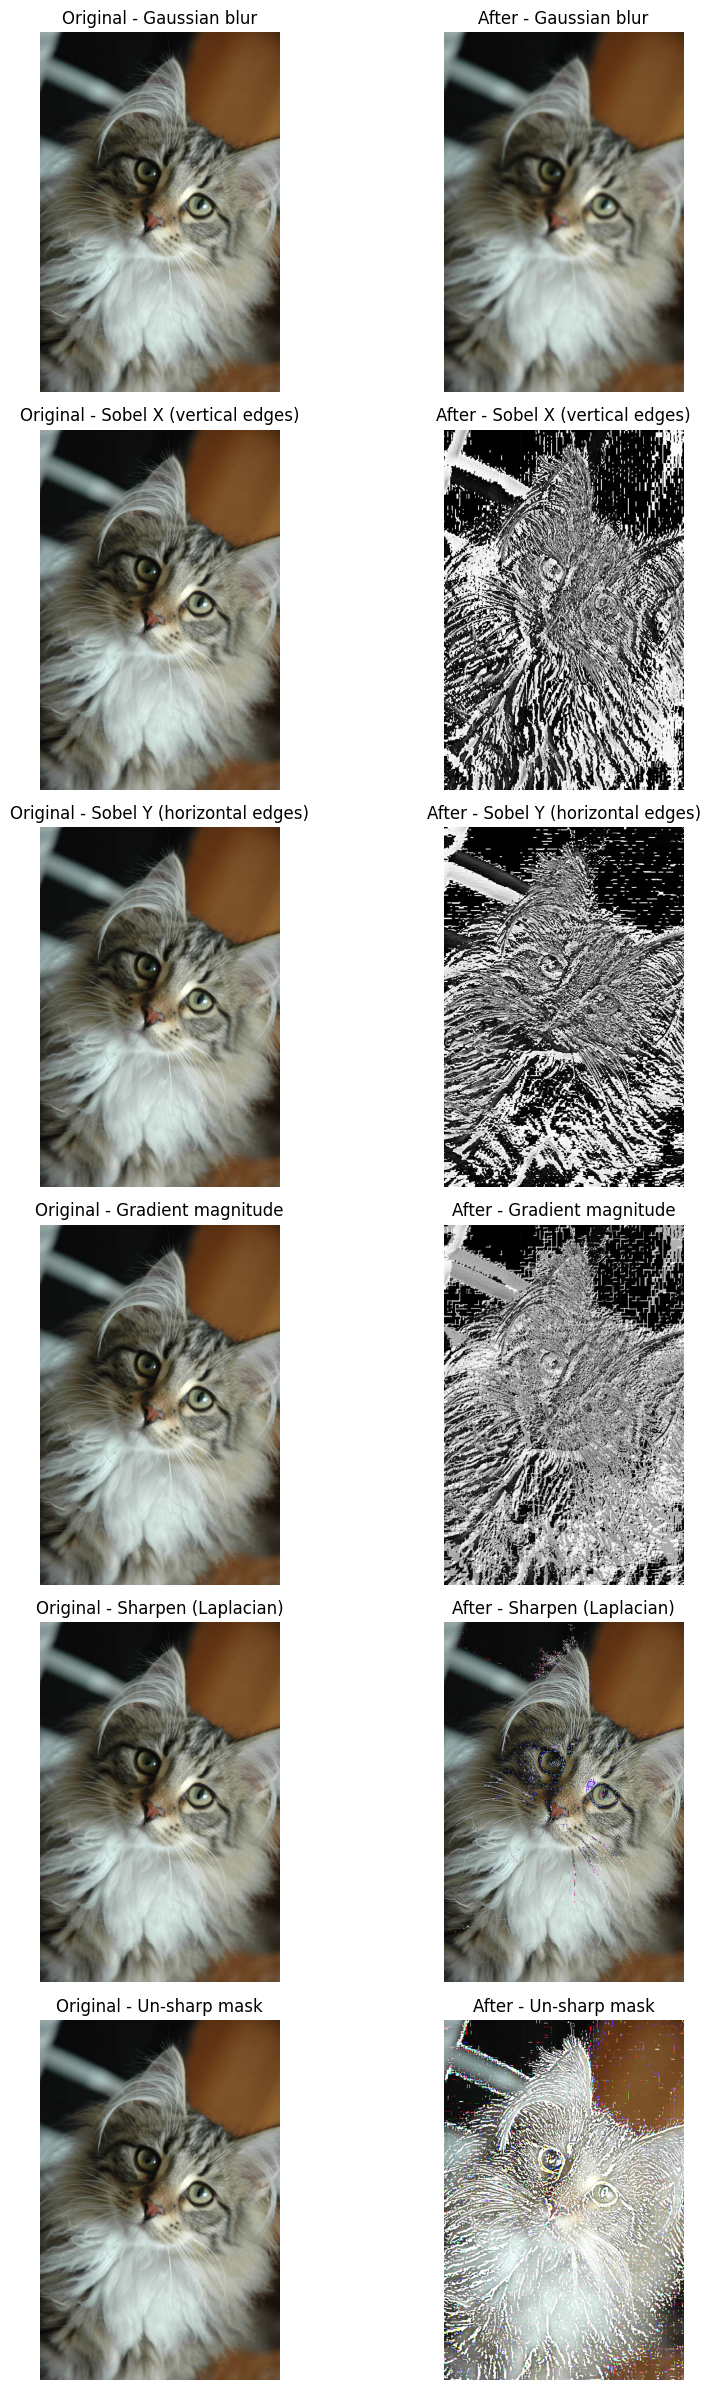

In [22]:
filters = {
    "Gaussian blur": gaussian_blur,
    "Sobel X (vertical edges)": sobel_x,
    "Sobel Y (horizontal edges)": sobel_y,
    "Gradient magnitude": gradient_magnitude,
    "Sharpen (Laplacian)": sharpen,
    "Un-sharp mask": unsharp_mask
}

n = len(filters)
fig, axes = plt.subplots(n, 2, figsize=(10, 4 * n))

for row, (name, func) in enumerate(filters.items()):
    axes[row, 0].imshow(original_image)
    axes[row, 0].set_title(f"Original - {name}")
    axes[row, 0].axis("off")

    result = func(original_image)
    cmap = "gray" if result.ndim == 2 else None
    axes[row, 1].imshow(result, cmap=cmap)
    axes[row, 1].set_title(f"After - {name}")
    axes[row, 1].axis("off")

plt.tight_layout()
plt.show()

### ** Problem 5. Classification
A type of widely used **models** is **classification**. Regression outputs a continuous value while classification outputs one of several pre-defined classes. In the most simple way, the classes are only two. For example, if we want to detect whether there's a cat on an image, we can have two classes: "cat" and "non-cat".

Explore the problem of classification. Implement and document one algorithm. Apply it to some real-world data. You can use the following checklist:

**Note:** If your paper is **about the algorithm**, consider **writing it from scratch**, not reusing it from a library.

* What is supervised learning? What do supervised learning models do?
* What is regression? What is classification?
* What types of problems does classification solve directly?
    * What types of problems can be reduced to classification?
* What's the difference between two-class and multi-class classification?
* Explore one algorithm for classification, e.g. logistic regression.
    * State the problem clearly
    * List all sssumptions of the modelling function
    * Describe the process: distances, error function, total loss, gradient descent, etc.; as needed
    * Implement the algorithm from scratch
* Select or generate a small dataset, suitable for classification. Run your algorithm as a sanity check
* Debug and solve any problems
* Waht is a confusion matrix?
* What metrics are used to score a classifier?
    * Accuracy, Precision, Recall, others
    * ROC curve, interpretation
* Select a real dataset
    * Explore it to get acquainted with what information it contains
    * Clean up the data if you need to do so
    * Perform classification
    * Score your classification model
    * Use your classifier to predict
        * Split the data into training and testing set
        * Optionally, perform **cross-validation**
    * Compare your implementation to another one, e.g. `scikit-learn`. They should give the same (or very similar) results
    * Communicate the results on your dataset
    * Optionally, publish your model on the Internet as a Web API

### ** Problem 6. Fourier Transform Applications: Images
Examine how Fourier transform is used in image processing. Consider writing the algorithms for transformation (forward and inverse) from scratch.

You may look at other transformations as well, for example, the **cosine transform** (used in JPEG images to achieve compression) or **wavelet transform**. You can use the following checklist:

* What is Fourier transformation? What information does it provide?
    * What do the forward and inverse transformation do? What are their inputs and outputs?
    * How do we interpret the results ("time domain" / "frequency domain")?
        * What does this mean in 2D? How does a 1D spectrum differ from a 2D spectrum?
        * What are the characteristic parts of a 2D spectrum?
    * Give some examples of well-known functions and their transformations
* What is Discrete Fourier Transform (DFT)?
    * Implement the algorithm in 2D
* How do we use DFT in image processing?
    * Provide examples
* Select an image and perform operations on it using your implementation of DFT
    * Low-pass filtering
    * High-pass filtering
    * Finding and removal of periodic component from an image
    * Fnding and removal of peaks
    * Shape analysis
* How do convolutions relate to DFT?
    
[This document](http://www.robots.ox.ac.uk/~az/lectures/ia/lect2.pdf), [this document](http://research.stowers.org/mcm/efg/Report/FourierAnalysis.pdf), and many others provide a good starting point. You can find a lot of examples in digital image processing and art using Fourier transformations.